In [1]:
from data_preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, KFold
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import tree
from sklearn import linear_model
from sklearn import svm

from sklearn.metrics import mean_absolute_error

# ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plotting settings
sns.set_style("ticks", rc={"font.size": 11})
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 11})

# 1. Hypothesis and Data Validation

### 1.0 Contig counts per sheep

In [32]:
# Sort contigs by decreasing sum over all samples
contig_sums = df_gene_CH4DMI.sum(axis=0)
sorted_contigs = contig_sums.sort_values(ascending=False).index
df_sorted = df_gene_CH4DMI[sorted_contigs]

In [33]:
# filter to most frequent contigs
df_sorted_freq = df_sorted[df_sorted.columns[:1000]]

In [34]:
map_label_to_color = {'low': '#dbb972', 'inter': '#76c6ba', 'high': '#167a72'}

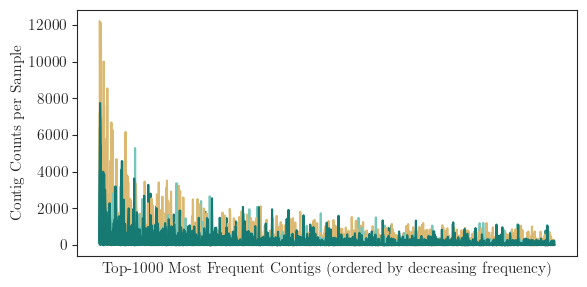

In [35]:
plt.figure(figsize=(6, 3))
for sample in df_sorted_freq.index:
    plt.plot(df_sorted_freq.loc[sample], color=map_label_to_color[sample.split('_')[1]])

plt.xlabel('Top-1000 Most Frequent Contigs')
plt.ylabel('Contig Counts per Sample')
plt.xticks([])
# plt.legend(title='Samples', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\k_dos\AppData\Local\Temp\ipykernel_16980\1727317714.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_100['Category'] = df_top_100.index.map(lambda x: x.split('_')[1])


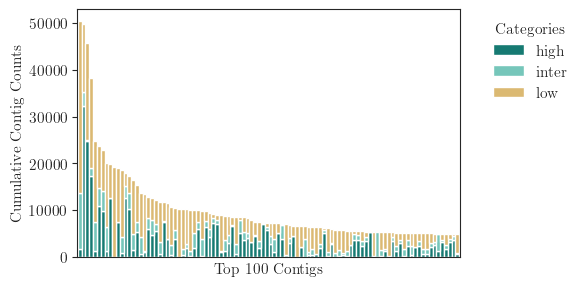

In [45]:
# Step 1: Calculate sums and filter the top 100 most frequent contigs
contig_sums = df_gene_CH4DMI.sum(axis=0)
top_100_contigs = contig_sums.sort_values(ascending=False).index[:100]
df_top_100 = df_gene_CH4DMI[top_100_contigs]

# Step 2: Categorize samples into 'low', 'inter', 'high'
map_label_to_color = {'low': '#dbb972', 'inter': '#76c6ba', 'high': '#167a72'}

# Step 3: Calculate average contig counts for each category
df_top_100['Category'] = df_top_100.index.map(lambda x: x.split('_')[1])
df_category_avg = df_top_100.groupby('Category').sum()

# Step 4: Plotting the stacked bar chart using seaborn
df_category_avg.T.plot(kind='bar', stacked=True, color=map_label_to_color, figsize=(6, 3), width=1)

# Customize the plot
plt.xlabel('Top 100 Contigs')
plt.ylabel('Cumulative Contig Counts')
plt.xticks([])
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()


### 1.1 Correlation: Contig counts to methane output

In [10]:
# calculate pairwise correlations
correlations = df_gene_CH4DMI.corrwith(df_gene_CH4DMI['CH4 g/kg DMI_average'], method='pearson')
# sort
df_tmp = pd.DataFrame(np.column_stack((-np.sort(-np.abs(correlations)), list(range(len(correlations))))), columns=['corr', 'id'])

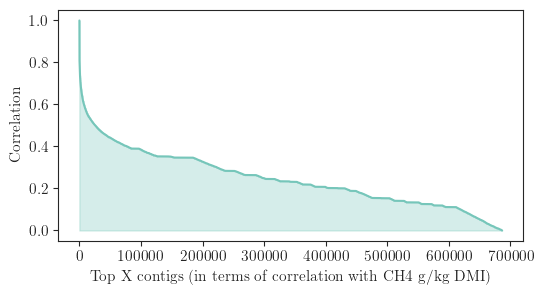

In [14]:
# plot
fig, ax = plt.subplots(1, figsize=(6,3))
sns.lineplot(data=df_tmp, x='id', y='corr', color=sns.color_palette("BrBG", 6)[4], ax=ax)
ax.fill_between(df_tmp['id'], df_tmp['corr'], color=sns.color_palette("BrBG", 6)[4], alpha=0.3)
ax.set_xlabel('Top X contigs (in terms of correlation with CH4 g/kg DMI)')
ax.set_ylabel('Correlation')
plt.show()

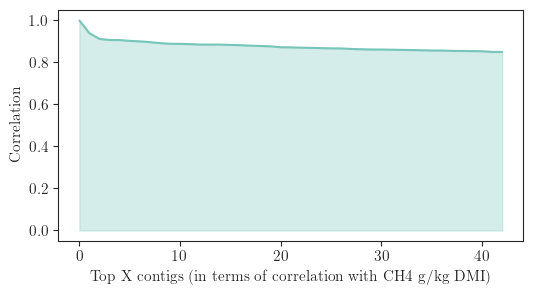

In [16]:
# zoom in
T = 0.85 # Pearson correlation threshold for plot

fig, ax = plt.subplots(1, figsize=(6,3))
sns.lineplot(data=df_tmp[df_tmp['corr'] > T], x='id', y='corr', color=sns.color_palette("BrBG", 6)[4], ax=ax)
ax.fill_between(df_tmp[df_tmp['corr'] > T]['id'], df_tmp[df_tmp['corr'] > T]['corr'], color=sns.color_palette("BrBG", 6)[4], alpha=0.3)
ax.set_xlabel('Top X contigs (in terms of correlation with CH4 g/kg DMI)')
ax.set_ylabel('Correlation')
plt.show()

### 1.2 Training a ML model to predict Methane

#### Hyperparameter tuning

In [17]:
def make_heatmap(ax, gs, params, plist0, plist1, make_cbar=False):
    """Helper to make a heatmap."""
    results = pd.DataFrame(gs.cv_results_)
    results[['param_'+params[0], 'param_'+params[1]]] = results[['param_'+params[0], 'param_'+params[1]]].astype(np.float64)
    # SH dataframe: get mean_test_score values for the highest iter
    scores_matrix = results.sort_values("iter").pivot_table(
        index="param_"+params[0],
        columns="param_"+params[1],
        values="mean_test_score",
        aggfunc="last",
    )

    im = ax.imshow(-scores_matrix, cmap='YlGnBu')

    ax.set_xticks(np.arange(len(plist1)))
    ax.set_xticklabels(["{:.0E}".format(x) for x in plist1])
    ax.set_xlabel(params[1])

    ax.set_yticks(np.arange(len(plist0)))
    ax.set_yticklabels(["{:.0E}".format(x) for x in plist0])
    ax.set_ylabel(params[0])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    if make_cbar:
        fig.subplots_adjust(right=1)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel("Test Error", rotation=-90, va="bottom")

In [30]:
# SVM Parameters
svr = svm.SVR(kernel='rbf', tol=1e-2)
gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

gsh = HalvingGridSearchCV(estimator=svr, param_grid=param_grid, factor=2, 
                          scoring='neg_mean_absolute_error').fit(X, Y)

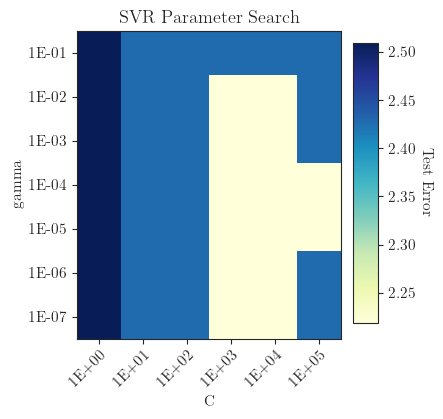

In [31]:
fig, ax = plt.subplots(figsize=(5,4))
make_heatmap(ax, gsh, params=list(param_grid.keys()), plist0=gammas, plist1=Cs, make_cbar=True)
ax.set_title("SVR Parameter Search")
plt.show()

In [24]:
# RF Parameters
maxdepth = [2,3,4,5]
trees = list(range(5, 30, 5))
param_grid = {"max_depth": maxdepth, "n_estimators": trees}
rf = RandomForestRegressor()

gsh = HalvingGridSearchCV(estimator=rf, param_grid=param_grid, factor=2, 
                          scoring='neg_mean_absolute_error').fit(X, Y)

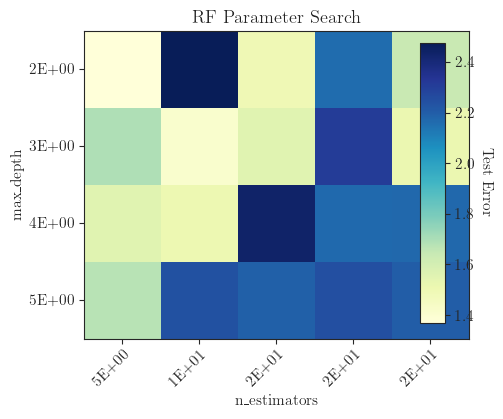

In [25]:
fig, ax = plt.subplots(figsize=(5,4))
make_heatmap(ax, gsh, params=list(param_grid.keys()), plist0=maxdepth, plist1=trees, make_cbar=True)
ax.set_title("RF Parameter Search")
plt.show()

In [26]:
# XGBoost Parameters
lrs = [1e-3, 1e-2, 1e-1, 1]
trees = list(range(5, 30, 5))
param_grid = {"learning_rate": lrs, "n_estimators": trees}
gb = GradientBoostingRegressor()

gsh = HalvingGridSearchCV(estimator=gb, param_grid=param_grid, factor=2, 
                          scoring='neg_mean_absolute_error').fit(X, Y)

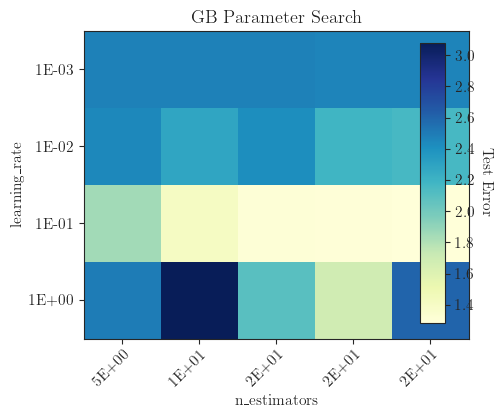

In [27]:
fig, ax = plt.subplots(figsize=(5,4))
make_heatmap(ax, gsh, params=list(param_grid.keys()), plist0=lrs, plist1=trees, make_cbar=True)
ax.set_title("GB Parameter Search")
plt.show()

In [28]:
# DT Parameters
maxdepth = [2,3,4,5]
minsamplessplit = list(range(2,5))
param_grid = {"max_depth": maxdepth, "min_samples_split": minsamplessplit}
dtree = tree.DecisionTreeRegressor()

gsh = HalvingGridSearchCV(estimator=dtree, param_grid=param_grid, factor=2, 
                          scoring='neg_mean_absolute_error').fit(X, Y)

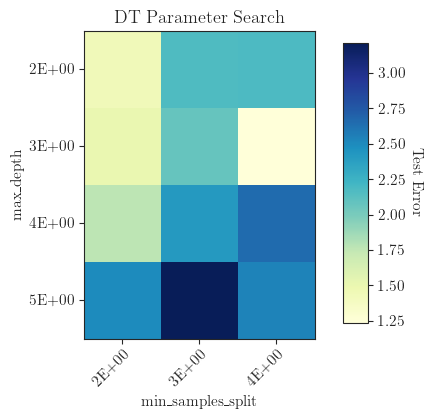

In [29]:
fig, ax = plt.subplots(figsize=(5,4))
make_heatmap(ax, gsh, params=list(param_grid.keys()), plist0=maxdepth, plist1=minsamplessplit, make_cbar=True)
ax.set_title("DT Parameter Search")
plt.show()

#### Run experiment

In [15]:
# define regressors to be included in test
linear_reg = linear_model.LinearRegression()
lasso = linear_model.LassoCV(cv=3, tol=1e-2)
svr = svm.SVR(kernel='rbf', gamma=1e-2, C=1000)
dtree3 = tree.DecisionTreeRegressor(max_depth=3)
dtree4 = tree.DecisionTreeRegressor(max_depth=4)
rf3 = RandomForestRegressor(n_estimators=20, max_depth=3)
rf4 = RandomForestRegressor(n_estimators=20, max_depth=4)
gb = GradientBoostingRegressor(n_estimators=20, learning_rate=1e-01)
regressor_list = [linear_reg, lasso, svr, dtree3, dtree4, rf3, rf4, gb]
regressor_names = ['Linear Regression', 'Lasso Regression', 'SVR', 'DT (max_depth=3)', 
                   'DT (max_depth=4)', 'RF (max_depth=3)', 'RF (max_depth=4)', 'XGBoost']

In [34]:
# run test
score_dict = {}
for i, reg in enumerate(regressor_list):
    print('Running', regressor_names[i], '...')
    s = cross_validate(reg, X, Y, cv=5, 
                       scoring=('neg_mean_absolute_error'),
                       return_train_score=True)
    score_dict[regressor_names[i]] = s

Running Linear Regression ...
Running Lasso Regression ...
Running SVR ...
Running DT (max_depth=3) ...
Running DT (max_depth=4) ...
Running RF (max_depth=3) ...
Running RF (max_depth=4) ...
Running XGBoost ...


#### Plot results

In [35]:
# prepare results for seaborn
results = pd.DataFrame.from_dict(score_dict, orient='index')
results =  results[results.columns[2:]] # remove training times
results.columns = ['MAE Test', 'MAE Train']
results['Regressor'] = results.index
results = results.melt(id_vars=["Regressor"], var_name="Metric", value_name="Value")
results[['Metric','evaluated on']] = results["Metric"].str.split(" ", expand=True)
results = results.Value.apply(pd.Series)\
    .merge(results, left_index = True, right_index = True)\
    .drop(["Value"], axis = 1)\
    .melt(id_vars = ['Regressor', 'Metric', 'evaluated on'], value_name = 'Value')\
    .drop("variable", axis = 1)
results['Value'] = -results['Value']

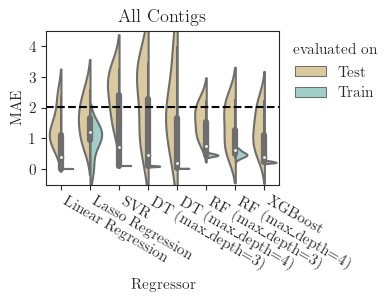

In [36]:
# plot
plt.figure(figsize=(3, 2))

g = sns.violinplot(data=results[results['Metric']=='MAE'], x="Regressor", y="Value", hue="evaluated on", split=True, 
                   palette='BrBG', scale='width')
g.set_xticklabels(g.get_xticklabels(), rotation=330, horizontalalignment='left')
g.set_title('All Contigs')
g.set_ylabel('MAE')
plt.axhline(y=np.average(np.abs(Y - np.average(Y))), linestyle='--', color='black')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), frameon=False)
g.set_ylim(-0.5, 4.5)
plt.savefig("Plots/Genes_to_CH4_DMI_MAE_allfeatures.pdf", bbox_inches='tight')
plt.show()

### 1.3 Feature selection using RF

In [37]:
# train RF
rf = RandomForestRegressor(max_depth=4, n_estimators=20)
rf.fit(X, Y)
# get feature importance
imps = rf.feature_importances_
# sort
df_tmp = pd.DataFrame(np.column_stack((-np.sort(-imps), list(range(len(imps))))), columns=['imp', 'id'])

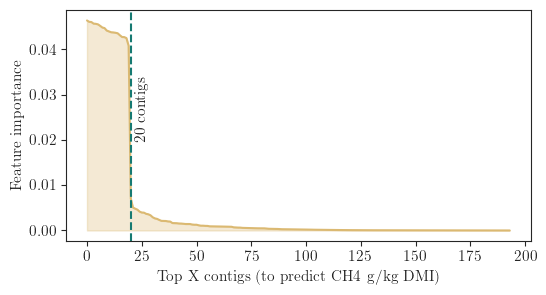

In [38]:
# plot
fig, ax = plt.subplots(1, figsize=(6,3))
sns.lineplot(data=df_tmp[df_tmp['imp']>0], x='id', y='imp', color=sns.color_palette("BrBG", 6)[1], ax=ax)
ax.fill_between(df_tmp[df_tmp['imp']>0]['id'], df_tmp[df_tmp['imp']>0]['imp'], color=sns.color_palette("BrBG", 6)[1], alpha=0.3)
ax.set_xlabel('Top X contigs (to predict CH4 g/kg DMI)')
ax.set_ylabel('Feature importance')
plt.axvline(x=20, c=sns.color_palette("BrBG", 6).as_hex()[5], ls='--')
ax.text(21.5, 0.02, '20 contigs', rotation = 90)

plt.show()

### 1.4 Feature selection on each individual training set

In [24]:
kf = KFold(n_splits=5)
results_list = []

for k, [tr, te] in enumerate(kf.split(X, Y)):
    print('Fold', k)
    X_tr, X_te, Y_tr, Y_te = X[tr], X[te], Y[tr], Y[te]
    
    # get important features
    rf = RandomForestRegressor(max_depth=4, n_estimators=20)
    rf.fit(X_tr, Y_tr)
    imps = rf.feature_importances_
    X_tr, X_te = X_tr[:, imps>0.02], X_te[:, imps>0.02]
    
    # train models
    for i, reg in enumerate(regressor_list):
        print('Running', regressor_names[i], '...')
        reg.fit(X_tr, Y_tr)
        results_list.append([regressor_names[i], k, 'Test', 
                             mean_absolute_error(Y_te, reg.predict(X_te))])
        results_list.append([regressor_names[i], k, 'Train', 
                             mean_absolute_error(Y_tr, reg.predict(X_tr))])
results = pd.DataFrame(results_list, columns=['Regressor', 'Fold', 'evaluated on', 'MAE'])  

Fold 0
Running Linear Regression ...
Running Lasso Regression ...
Running SVR ...
Running DT (max_depth=3) ...
Running DT (max_depth=4) ...
Running RF (max_depth=3) ...
Running RF (max_depth=4) ...
Running XGBoost ...
Fold 1
Running Linear Regression ...
Running Lasso Regression ...
Running SVR ...
Running DT (max_depth=3) ...
Running DT (max_depth=4) ...
Running RF (max_depth=3) ...
Running RF (max_depth=4) ...
Running XGBoost ...
Fold 2
Running Linear Regression ...
Running Lasso Regression ...
Running SVR ...
Running DT (max_depth=3) ...
Running DT (max_depth=4) ...
Running RF (max_depth=3) ...
Running RF (max_depth=4) ...
Running XGBoost ...
Fold 3
Running Linear Regression ...
Running Lasso Regression ...
Running SVR ...
Running DT (max_depth=3) ...
Running DT (max_depth=4) ...
Running RF (max_depth=3) ...
Running RF (max_depth=4) ...
Running XGBoost ...
Fold 4
Running Linear Regression ...
Running Lasso Regression ...
Running SVR ...
Running DT (max_depth=3) ...
Running DT (max_d

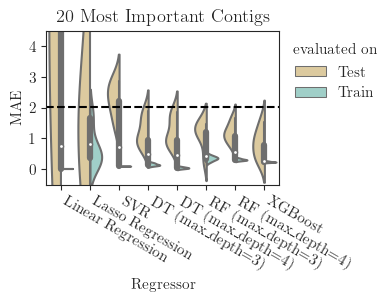

In [25]:
plt.figure(figsize=(3, 2))

g = sns.violinplot(data=results, x="Regressor", y="MAE", hue="evaluated on", split=True, 
                   palette='BrBG', scale='width', inner='box')
g.set_xticklabels(g.get_xticklabels(), rotation=330, horizontalalignment='left')
g.set_title('20 Most Important Contigs')
plt.axhline(y=np.average(np.abs(Y - np.average(Y))), linestyle='--', color='black')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), frameon=False)
g.set_ylim(-0.5, 4.5)
plt.savefig("Plots/Genes_to_CH4_DMI_MAE_impfeatures.pdf", bbox_inches='tight')
plt.show()